In [111]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

In [115]:
def random_graph(n, prob=0.7):
    matrix = np.random.choice([0, 1], size=(n, n), p=[1 - prob, prob])
    np.fill_diagonal(matrix, 0)
    matrix = np.triu(matrix) + np.triu(matrix, k=1).T
    return matrix

def compute_cut(graph, partition, weights):
    return np.sum(0.25 * weights * graph * (1 - np.outer(partition, partition)))

def brute_force(graph, weights):
    n = graph.shape[0]
    best_cost_brute = 0
    for b in range(2**n):
        x = np.array([int(t) for t in reversed(list(bin(b)[2:].zfill(n)))])
        cost = np.sum(weights * graph * np.outer(x, 1-x))
        if best_cost_brute < cost:
            best_cost_brute = cost
    return best_cost_brute

def is_psd(matrix):
    eigenvalues, _ = np.linalg.eigh(matrix)
    return np.all(eigenvalues >= 0)

def sdp(graph, weights):
    n = graph.shape[0]
    P = cp.Variable((n,n), PSD=True)
    objective = cp.Minimize(cp.sum(cp.multiply(cp.multiply(P, graph), weights)))
    constraints = [cp.diag(P) == 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    lambdas, Q = np.linalg.eigh(P.value + np.eye(n) * 1e-4)
    X = np.diag(np.sqrt(lambdas)) @ Q.T
    return X

def hyperplane_rounding(X):
    n = X.shape[0]
    r = np.random.randn(n)
    return np.sign(X.T @ r)

def simulate(n_iter=100, n=10, p=0.4):
    percentage = 0
    weights = np.ones((n,n))
    for _ in range(n_iter):
        graph = random_graph(n, p)
        X = sdp(graph, weights)
        approx_ans = compute_cut(graph, hyperplane_rounding(X), weights)
        true_ans = brute_force(graph, weights)
        if true_ans == 0: 
            continue
        percentage += approx_ans / true_ans / n_iter
    return percentage

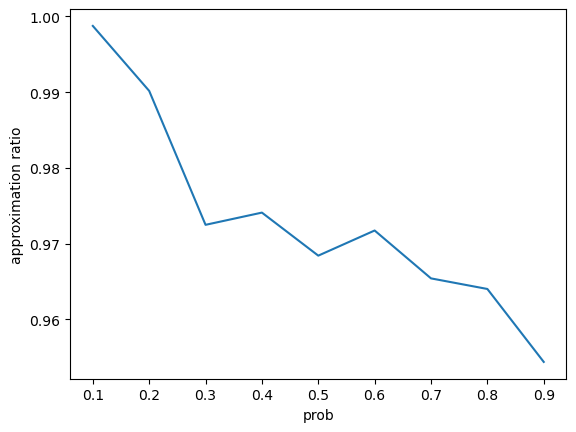

In [117]:
acc = []
ps = np.arange(0.1,1,0.1)
for p in ps:
    acc.append(simulate(100,p=p))

plt.plot(ps, acc)
plt.xlabel('prob')
plt.ylabel('approximation ratio')
plt.show()